In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from affine import Affine

# Creation of PCA Model and Determining Number of Components

In [68]:
def process_greenspace_path(ndvi_path, aqi_path, soil_moisture_path, land_temp_path):
    """
    Function to process and merge all path data per greenspace

    :param ndvi_path: Path to NDVI data
    :param aqi_path: Path to AQI data
    :param soil_moisture_path: Path to soil moisture data
    :param land_temp_path: Path to land temperature data
    :return:
    """

    ndvi_data = pd.read_csv(ndvi_path)
    aqi_data = pd.read_csv(aqi_path)
    soil_moisture_data = pd.read_csv(soil_moisture_path)
    land_temp_data = pd.read_csv(land_temp_path)

    # First merge AQI and NDVI data frames
    aqi_ndvi_merge = pd.merge(ndvi_data, aqi_data, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_aqi_ndvi_merge = aqi_ndvi_merge.copy().dropna()

    # Combine coordinate and date columns
    cleaned_aqi_ndvi_merge.loc[:, 'Date'] = cleaned_aqi_ndvi_merge['Date_x'].combine_first(cleaned_aqi_ndvi_merge['Date_y'])
    cleaned_aqi_ndvi_merge.loc[:, 'Coordinates'] = cleaned_aqi_ndvi_merge['Coordinates_x'].combine_first(cleaned_aqi_ndvi_merge['Coordinates_y'])

    # Drop redundant columns
    cleaned_aqi_ndvi_merge.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    cleaned_aqi_ndvi_merge.rename(columns={'Value_x': 'NDVI', 'Value_y': 'AQI'}, inplace=True)

    # Merge soil moisture and land temp dataframes
    soil_moisture_land_temp_merge = pd.merge(soil_moisture_data, land_temp_data, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_soil_moisture_land_temp_merge = soil_moisture_land_temp_merge.copy().dropna()

    # Combine coordinate and date columns
    cleaned_soil_moisture_land_temp_merge.loc[:, 'Date'] = cleaned_soil_moisture_land_temp_merge['Date_x'].combine_first(cleaned_soil_moisture_land_temp_merge['Date_y'])
    cleaned_soil_moisture_land_temp_merge.loc[:, 'Coordinates'] = cleaned_soil_moisture_land_temp_merge['Coordinates_x'].combine_first(cleaned_soil_moisture_land_temp_merge['Coordinates_y'])

    # Drop redundant columns
    cleaned_soil_moisture_land_temp_merge.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Rename Value columns to NDVI and AQI
    cleaned_soil_moisture_land_temp_merge.rename(columns={'Value_x': 'Soil_Moisture', 'Value_y': 'Land_Temp'}, inplace=True)

    # Merge two dataframes together
    final_merged_data = pd.merge(cleaned_aqi_ndvi_merge, cleaned_soil_moisture_land_temp_merge, left_index=True, right_index=True, how="inner")

    # Drop missing values
    cleaned_final_merged = final_merged_data.copy().dropna()

    # Combine coordinate and date columns
    cleaned_final_merged.loc[:, 'Date'] = final_merged_data['Date_x'].combine_first(final_merged_data['Date_y'])
    cleaned_final_merged.loc[:, 'Coordinates'] = final_merged_data['Coordinates_x'].combine_first(final_merged_data['Coordinates_y'])

    # Drop redundant columns
    cleaned_final_merged.drop(columns=['Date_x', 'Date_y', 'Coordinates_x', 'Coordinates_y'], inplace=True)

    # Apply cumulative cut on NDVI to remove outliers
    ndvi_data = cleaned_final_merged['NDVI'].copy()
    sorted_ndvi_data = ndvi_data.sort_values().reset_index(drop=True)

    # Calculate cumulative percentages
    cumulative_percentage = sorted_ndvi_data.rank(pct=True)

    # Define cut-off range
    lower_cut = 0.02
    upper_cut = 0.98

    # Filter NDVI values within range
    filtered_NDVI_data = sorted_ndvi_data[
        (cumulative_percentage >= lower_cut) &
        (cumulative_percentage <= upper_cut)
        ]

    # Set lower and upper values for NDVI
    lower_cut_value = filtered_NDVI_data.min()
    upper_cut_value = filtered_NDVI_data.max()

    # Keep NDVI rows where NDVI value is within range
    cleaned_final_merged_cut = cleaned_final_merged[
        (cleaned_final_merged['NDVI'] >= lower_cut_value) &
        (cleaned_final_merged['NDVI'] <= upper_cut_value)
        ]

    return cleaned_final_merged_cut

In [69]:
# Data dictionary containing all paths per greenspace
greespace_files = {
    "Vondelpark": {
        "NDVI": "Datasets/Sentinel-2/Vondel_NDVI/Vondel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Vondelpark/Vondel_AirQualityIndex/Vondel_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Vondelpark/Vondel_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Vondelpark/Vondel_LandTemp_csv.csv",
    },
    "Westerpark": {
        "NDVI": "Datasets/Sentinel-2/Wester_NDVI/Wester_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Westerpark/Wester_AirQualityIndex/Wester_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Westerpark/Wester_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Westerpark/Wester_LandTemp_csv.csv",
    },
    "Amstelpark": {
        "NDVI": "Datasets/Sentinel-2/Amstel_NDVI/Amstel_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Amstelpark/Amstel_AirQualityIndex/Amstel_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Amstelpark/Amstel_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Amstelpark/Amstel_LandTemp_csv.csv",
    },
    "Rembrandtpark": {
        "NDVI": "Datasets/Sentinel-2/Rembrandt_NDVI/Rembrandt_NDVI_csv.csv",
        "AQI": "Datasets/Sentinel-5P/Rembrandtpark/Rembrandt_AirQualityIndex/Rembrandt_AirQualityIndex_csv.csv",
        "soil_moisture": "Datasets/Sentinel-1/Rembrandtpark/Rembrandt_SoilMoisture_csv.csv",
        "land_temp": "Datasets/Sentinel-3/Rembrandtpark/Rembrandt_LandTemp_csv.csv",
    },
}

In [70]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces = {}
for park, paths in greespace_files.items():
    greenspaces[park] = process_greenspace_path(paths["NDVI"], paths["AQI"], paths['soil_moisture'], paths['land_temp'])

In [71]:
greenspaces['Vondelpark']

,NDVI,AQI,Soil_Moisture,Land_Temp,Date,Coordinates
0,0.074513,118.564835,0.076748,266.87164,2024-03-01,"626205.0, 5802955.0"
1,0.072915,118.564835,0.076748,266.87164,2024-03-01,"626215.0, 5802955.0"
2,0.071516,118.564835,0.095758,266.87164,2024-03-01,"626225.0, 5802955.0"
3,0.068068,118.564835,0.095758,266.87164,2024-03-01,"626235.0, 5802955.0"
4,0.061473,118.564835,0.079892,266.87164,2024-03-01,"626245.0, 5802955.0"
...,...,...,...,...,...,...
271195,0.184967,99.465904,0.068921,285.16400,2024-06-01,"628155.0, 5801835.0"
271196,0.153550,99.465904,0.053422,285.16400,2024-06-01,"628165.0, 5801835.0"
271197,0.182766,99.465904,0.053422,285.16400,2024-06-01,"628175.0, 5801835.0"
271198,0.143232,99.465904,0.122898,285.16400,2024-06-01,"628185.0, 5801835.0"


In [72]:
def pca_on_greenspace(greenspaces, components):
    """
    Function to perform PCA on each green space

    :param greenspace: Dictionary of green space data
    :return:
    """

    pca_results = {}

    for park, dataframe in greenspaces.items():

        # Select relevant columns for PCA
        features = ['NDVI', 'AQI', 'Soil_Moisture', 'Land_Temp']
        features_df = dataframe[features]

        # Standardize data with mean 0 and SD 1 due to PCA being sensitive to scale
        scaler = StandardScaler()
        scaled_data =  scaler.fit_transform(features_df)

        # Apply PCA
        pca_model = PCA(n_components=components)
        principal_components = pca_model.fit_transform(scaled_data)

        # Store results in dictionary
        pca_results[park] = {
            'principal_components': principal_components,
            'explained_variance': pca_model.explained_variance_ratio_,
            'pca_model': pca_model
        }

        # Print variance explained by each component
        print(f"PCA for {park}:")
        print(f"Explained Variance Ratio: {pca_model.explained_variance_ratio_}")

        # Convert PCA results back to DataFrame for further analysis
        if components == 4:
            pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
        elif components == 3:
            pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

        pca_results[park]['pca_df'] = pca_df


    return pca_results

pca_results = pca_on_greenspace(greenspaces, 4)

PCA for Vondelpark:
Explained Variance Ratio: [0.54934018 0.2519505  0.15384184 0.04486748]
PCA for Westerpark:
Explained Variance Ratio: [0.5418355  0.25138261 0.13785596 0.06892594]
PCA for Amstelpark:
Explained Variance Ratio: [0.56683513 0.2338745  0.16136887 0.0379215 ]
PCA for Rembrandtpark:
Explained Variance Ratio: [0.58262685 0.25053519 0.11929271 0.04754525]


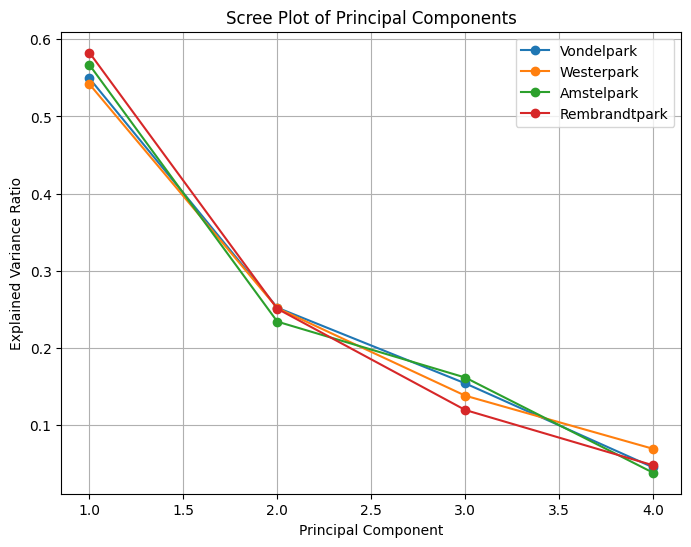

In [73]:
# Function to plot scree plot
def plot_scree(pca_results):
    plt.figure(figsize=(8, 6))

    for park, results in pca_results.items():
        explained_variance = results['pca_model'].explained_variance_ratio_
        components = np.arange(1, len(explained_variance) + 1)

        plt.plot(components, explained_variance, marker='o', label=park)

    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot of Principal Components')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function with your PCA results
plot_scree(pca_results)

Looking at the attained results along with the above scree plot, it is appropriate to retain 3 principal components as these capture 87%-95% of the total variance. Adding the fourth component would add little additional information at the cost of making the model more complicated

# Creation of Custom Index

In [74]:
# Store all data of greenspaces in a dictionary for easy access
greenspaces_index = {}
for park, paths in greespace_files.items():
    greenspaces_index[park] = process_greenspace_path(paths["NDVI"], paths["AQI"], paths['soil_moisture'], paths['land_temp'])

In [75]:
def apply_weights(dataframe, weights):
    """
    Function to apply weights to factors

    :param dataframe:
    :param weights:
    :return:
    """
    weighted_df = dataframe.copy()
    for factor, weight in weights.items():
        if factor in dataframe.columns:
            weighted_df[factor] *= weight

    return weighted_df

In [76]:
def pca_custom_index(greenspaces, weights):
    """
    Function to apply pca model to create custom index by making use of different environmental variables

    :param greenspaces: Dictionary containing file paths to environmental variables per greenspace
    :param weights: Weights to apply to different environmental variables
    :return:
    """
    for park, df in greenspaces.items():

        # Select relevant columns for PCA
        features = ['NDVI', 'AQI', 'Soil_Moisture', 'Land_Temp']
        features_df = df[features]

        # Standardize data with mean 0 and SD 1 due to PCA being sensitive to scale
        scaler = StandardScaler()
        scaled_data =  scaler.fit_transform(features_df)

        # Convert scaled data back to DataFrame
        scaled_df = pd.DataFrame(scaled_data, columns=features)

        # Apply weights to factors after standardizing
        weighted_df = apply_weights(scaled_df, weights)

        # Perform PCA with 3 components
        pca_model = PCA(n_components=3)
        principal_components = pca_model.fit_transform(weighted_df)

        # Store results
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

        # Compute the custom index using the principal components
        pca_df['CustomIndex'] = (
            pca_df['PC1'] * pca_model.explained_variance_ratio_[0] +
            pca_df['PC2'] * pca_model.explained_variance_ratio_[1] +
            pca_df['PC3'] * pca_model.explained_variance_ratio_[2]
        )

        # Scale custom index to range 1-100
        min_val = pca_df['CustomIndex'].min()
        max_val = pca_df['CustomIndex'].max()

        pca_df['CustomIndex_Scaled'] = ((pca_df['CustomIndex'] - min_val) / (max_val - min_val)) * (100 - 1) + 1

        # Add the index to original dataframe
        custom_index = pca_df['CustomIndex_Scaled']
        greenspaces[park].drop(columns=['Custom_Index'], errors='ignore', inplace=True)
        greenspaces[park] = greenspaces[park].reset_index(drop=True)
        custom_index = custom_index.reset_index(drop=True)
        greenspaces[park]['Custom_Index'] = custom_index

        print(f"Index calculated and applied to {park}")

    return greenspaces

# Define weights for the environmental factors based on importance
# weights = {
#     'NDVI': 0.50,
#     'Land_Temp': 0.25,
#     'Soil_Moisture': 0.15,
#     'AQI': 0.1
# }

weights = {
    'NDVI': 0.40,
    'Land_Temp': 0.35,
    'Soil_Moisture': 0.15,
    'AQI': 0.1
}

pca_results = pca_custom_index(greenspaces, weights)

Index calculated and applied to Vondelpark
Index calculated and applied to Westerpark
Index calculated and applied to Amstelpark
Index calculated and applied to Rembrandtpark


In [77]:
# Due to missing data in some of the satellite data, only months 02 - 07 are available
pca_results['Vondelpark']['Date'].unique()

array(['2024-03-01', '2024-02-01', '2024-04-01', '2024-05-01',
       '2024-07-01', '2024-06-01'], dtype=object)

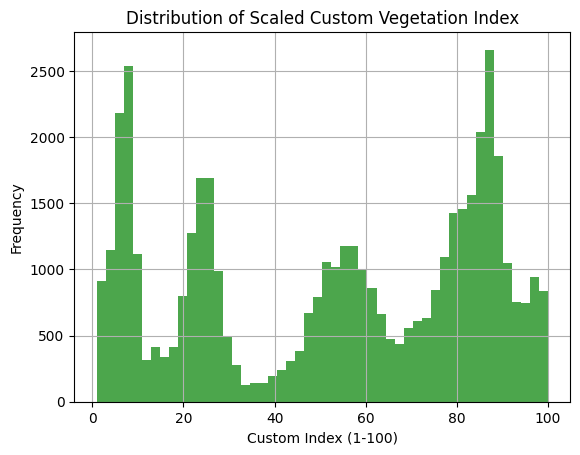

In [78]:
# Visualise distribution of index value
plt.hist(pca_results['Amstelpark']['Custom_Index'], bins=50, alpha=0.7, color='green')
plt.title('Distribution of Scaled Custom Vegetation Index')
plt.xlabel('Custom Index (1-100)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Exporting Index to GeoTIFF

In [79]:
def export_greenspace_to_geotiff(greenspaces_with_index, output_directory):
    """
    Function to export greenspaces to GeoTiff using custom index as value

    :param greenspaces_with_index: Dictionary containing greenspace dataframes with index
    :param output_directory:
    :return:
    """

    for park, dataframe in greenspaces_with_index.items():
        # Convert coordinates to float values
        dataframe[['X', 'Y']] = dataframe['Coordinates'].str.split(',', expand=True).astype(float)
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])

        # Establish row index to keep data aligned
        dataframe['Row_Index'] = dataframe.index

        # Group by unique months and export each month as a separate GeoTIFF
        unique_months = dataframe['Date'].dt.to_period('M').unique()

        for month in unique_months:
            month_data = dataframe[dataframe['Date'].dt.to_period('M') == month]

            # Save monthly data as CSV for verification
            csv_output_path = f"{output_directory}/CSV_Files/{park}_{month}.csv"
            month_data.to_csv(csv_output_path, index=False)
            print(f"CSV saved for {park} - {month}: {csv_output_path}")

            # Create pivot table for spatial representation on a grid
            pivot_table = month_data.pivot(index = 'X', columns = 'Y', values = 'Custom_Index')

            # Convert to numpy array
            greenspace_array = pivot_table.to_numpy()

            if greenspace_array is None or greenspace_array.size == 0:
                print(f"Skipping {park} for {month} due to empty data")
                continue

            # Ensure X and Y coordinates are sorted correctly
            y_coords = np.sort(pivot_table.columns.values)
            x_coords = np.sort(pivot_table.index.values)

            # Define raster transformation
            transform = from_origin(
                x_coords.min(),  # Upper-left X coordinate
                y_coords.min(),  # Upper-left Y coordinate
                abs(x_coords[1] - x_coords[0]),  # X resolution
                abs(y_coords[1] - y_coords[0]) # Y resolution
            )

            # Add 90-degree rotation
            transform = transform * Affine.rotation(-90)

            # Output file path
            output_path = f"{output_directory}/{park}_{month}.tif"

            # Write to GeoTIFF
            with rasterio.open(
                    output_path, 'w',
                    driver = 'GTiff',
                    height = greenspace_array.shape[0],
                    width = greenspace_array.shape[1],
                    count = 1,
                    dtype = greenspace_array.dtype,
                    crs= "EPSG:32631",  # Using system UTM 31U
                    transform = transform
            ) as dst:
                dst.write(greenspace_array, 1)

            print(f"GeoTIFF saved for {park} - {month}: {output_path}")

export_greenspace_to_geotiff(pca_results, 'Datasets/CustomIndex')

CSV saved for Vondelpark - 2024-03: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-03.csv
GeoTIFF saved for Vondelpark - 2024-03: Datasets/CustomIndex/Vondelpark_2024-03.tif
CSV saved for Vondelpark - 2024-02: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-02.csv
GeoTIFF saved for Vondelpark - 2024-02: Datasets/CustomIndex/Vondelpark_2024-02.tif
CSV saved for Vondelpark - 2024-04: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-04.csv
GeoTIFF saved for Vondelpark - 2024-04: Datasets/CustomIndex/Vondelpark_2024-04.tif
CSV saved for Vondelpark - 2024-05: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-05.csv
GeoTIFF saved for Vondelpark - 2024-05: Datasets/CustomIndex/Vondelpark_2024-05.tif
CSV saved for Vondelpark - 2024-07: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-07.csv
GeoTIFF saved for Vondelpark - 2024-07: Datasets/CustomIndex/Vondelpark_2024-07.tif
CSV saved for Vondelpark - 2024-06: Datasets/CustomIndex/CSV_Files/Vondelpark_2024-06.csv
GeoTIFF saved for Vondelpark - 2024-06: 